In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import stats
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema
import re

PValue=.01

In [15]:
def Create_DF(Speed_Dic,file,path):
    DF_Dic ={}
    counter = 2
    print('File name - ',file+'\n')
    name_pattern = file.split('-')[0]
    assert file.find('.json') != -1, ('Trying to read a non .json file '+file)
    temp = pd.read_json(path+file, orient = 'records')
    
    progNames = []
    for j in range(0,temp.shape[0]):
        command = temp.iloc[j,0]['command']
        
        if command.find('lpeg') != -1:
            found_prog = 'lpeg'
        elif command.find('pexl') != -1:
            found_prog = 'pexl'
        elif command.find('rosie') != -1:
            found_prog = 'rosie'

        print('   Pattern Name - ',name_pattern+'_'+found_prog)
        tempDF = pd.DataFrame(columns = [found_prog,found_prog+'_Speed'])
        tempDF[found_prog] = temp.iloc[j,0]['times']
        warmup_runs = len(Speed_Dic[name_pattern+'_'+found_prog]) - tempDF[ found_prog ].size
        # There are 5 warm-up iterations before each run is recorded. These warmups are in the transcript but not 
        #  the actual data.
        print('      Found',warmup_runs,'warm up runs.\n')
        #print('Length of json ',tempDF[found_prog].shape[0],' Length of .txt ',len(Speed_Dic[name_pattern+'_'+found_prog]))
        tempDF[found_prog+'_Speed'] = Speed_Dic[name_pattern+'_'+found_prog][warmup_runs:]

        key_name = name_pattern+'_'+found_prog
        if key_name in DF_Dic.keys():
            print('Found repeat key name ',key_name,' renaming to ',key_name+str(counter))
            key_name = key_name+str(counter)
            counter += 1

        DF_Dic[key_name] = tempDF.copy()
    return DF_Dic

In [ ]:
def Read_Transcript2(path):
    print(path)
    with open(path) as f:
        lines = f.readlines()

    f.close()

    section = None
    speed = 100

    find_prog_patt = '(pexl|lpeg|rosie).* (\\w+) +\\d+'
    find_prog_patt_searcher = re.compile(find_prog_patt)

    speed_limit_pattern = ' (\\d+)\n'
    speed_limit_searcher = re.compile(speed_limit_pattern)

    Speed_Dic = {}
    tempList = []
    speedList = []
    
    for i in range(0,len(lines)):
        line = lines[i]

        if line.find('Benchmark') > -1:
            match = find_prog_patt_searcher.search(line)
            assert len(match.groups() ) == 2,('Matched to many things in the pattern identifier '+match.groups())
            patt_prog = match.groups()[1]+'_'+match.groups()[0]
            if section is None:
                section = patt_prog
            else:
                Speed_Dic[section] = tempList
                section = patt_prog
                tempList = []
            print(section, i)
        elif line.find('CPU_Speed_Limit') > -1:
            match = speed_limit_searcher.search(line)
            if match is None:
                print('ignoring line ', line,i) #I use this output to check that only a few lines are being ignored
                continue
            assert len(match.groups() ) == 1,'Matched to many things looking for speed limit changes'
            speed = int(match.groups()[0])
            if speedList:
                speedList.append(speed)
        elif line.find('Running ') > -1:
            speedList.append(speed)
        elif line.find('Done.') > -1:
            tempList.append( (speedList) )
            speedList = []

        if i == (len(lines)-1):
            Speed_Dic[section] = tempList

    return Speed_Dic

In [18]:
def Real_File(string):
    if string.find('~') > -1:
        return False
    elif string.find('#') > -1:
        return False
    else:
        return True

Folders with Files in them

In [19]:
plugged_in_no_brower_7_20_22 = 'Plugged_In_No_Browser_7-20-22' # 10 runs each no enough for statistics
plugged_in_no_brower_7_21_22 = 'Plugged_In_No_Browser_7-21-22' # 50 runs each
plugged_in_with_brower_7_26_22 = 'Plugged_In_With_Browser_7-26-22' # 50 runs attemptings to see slow downs with new
                                                                   # functionality to show processor speeds

battery_two_test_at_once_7_27_22 = 'Battery_Two_Test_At_Once_7_27_22' # Ran two tests at once to test output 
                                                                      # of cpu speed outputs
plugged_in_no_brower_8_9_22 = 'Plugged_In_No_Browser_8_9_22' # 1,000 runs of each program on two patterns. Looking
                                                             # to test Trot's theory that VM's don't stabilize 
                                                             # runtime b/c to complicated.
plugged_in_no_brower_8_10_22 = 'Plugged_In_No_Browser_8_10_22' #Repeating just the abram_lpeg performance test from
                                                               # 8-9-22 to see if similar distro occurs
currentPath = plugged_in_no_brower_8_9_22

In [34]:
# This creates a dictionary whose keys are the pattern_program combo found in the transcript. The values are a 
#  two dimensional dataframe. 1 column is the duration of each iteration. 2nd column is a list of the "cpu speed/s"
#  during that iteration.

#colors = ['green','blue','red']

folder_path = currentPath +'/'
first_layer = os.listdir(currentPath)

overallDF_Dic = {}

for folder in first_layer:
    print(folder)
    if folder.find('Run') > -1:
        second_layer = os.listdir(folder_path+folder)
        for file in second_layer:
            if (file.find('.txt') > -1) and Real_File(file):
                Speed_Dic = Read_Transcript2(folder_path+folder+'/'+file)
                print(Speed_Dic.keys())
        for file in second_layer:
            if (file.find('.json') > -1) and Real_File(file):
                name = file.split('-')[0]
                overallDF_Dic[folder+'-'+name] = Create_DF(Speed_Dic,file,folder_path+folder+'/')
print(overallDF_Dic.keys())

.DS_Store
Other
Run1
Plugged_In_No_Browser_8_9_22/Run1/transcript.txt
abram_lpeg 18
abram_pexl 8064
abram_rosie 13095
longword_lpeg 19148
longword_pexl 27194
longword_rosie 32225
dict_keys(['abram_lpeg', 'abram_pexl', 'abram_rosie', 'longword_lpeg', 'longword_pexl', 'longword_rosie'])
File name -  abram-captureAll-22941.json

   Pattern Name -  abram_lpeg
      Found 5 warm up runs.

   Pattern Name -  abram_pexl
      Found 5 warm up runs.

   Pattern Name -  abram_rosie
      Found 5 warm up runs.

File name -  longword-captureAll-8551.json

   Pattern Name -  longword_lpeg
      Found 5 warm up runs.

   Pattern Name -  longword_pexl
      Found 5 warm up runs.

   Pattern Name -  longword_rosie
      Found 5 warm up runs.

dict_keys(['Run1-abram', 'Run1-longword'])


### Function to calculate bandwidth value from data assuming bimodal distrobution

In [36]:
# Magic number comes from the wiki article on kde and how to estimate bandwidth from the data.
# The wiki article suggested .9 as a good approximation for bimodal/multimodal distrubutions.
def band_est(dataSet):
    magic_num = .9
    n = len(dataSet)
    samp_std = dataSet.std()
    q1 = np.quantile(dataSet,.25)
    q3 = np.quantile(dataSet,.75)
    IQR = q3-q1
    bandwidth_estimate = magic_num * min(samp_std,IQR/1.34)*n**(-1/5)
    return bandwidth_estimate

Funtion to calculate and plot the kde graphs 

In [37]:
def kde_graph(data,title,ln_flag):
    
    dataArray = np.asarray(data[:,0], dtype=float)
    if ln_flag:
        dataArray = np.log(dataArray)
    
    dataArray = dataArray.reshape(-1,1)
    
    
    #dataArray = np.log(dataArray[0])
    
    fineness_of_graph = 10000
    
    band_estimate = band_est(dataArray)

    kde = KernelDensity(kernel='gaussian', bandwidth= band_estimate ).fit(dataArray)
    s = np.linspace(min(dataArray)[0],max(dataArray)[0],fineness_of_graph)
    e = kde.score_samples(s.reshape(-1,1))
    
    if title.find('lpeg') != -1:
        color = 'green'
    elif title.find('rosie') != -1:
        color = 'red'
    elif title.find('pexl') != -1:
        color = 'blue'
    else:
        color = 'black'
    
    plt.plot(s, e, c = color)
    plt.axhline(y=0)
    
    mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
    #print("Minima: X:", s[mi],'\n        Y:', e[mi], '\n')
    #print("\nMaxima: X:", s[ma],'\n        Y:', e[ma],'\n')
    
    #if min(e[mi]) < -100:
    #    plt.yscale('symlog')
    
    mean = np.mean(dataArray)
    median = np.median(dataArray)
    
    for points in data:
        temp = np.mean(points[1])
        if ln_flag:
            point = np.log(points[0])
        else:
            point = points[0]
        if temp < 100:
            
            norm = point-min(dataArray)[0]

            
            stepSize = (max(dataArray)[0] - min(dataArray)[0])/fineness_of_graph
            
            dif = round( norm/stepSize) -1
            
            plt.scatter(point,e[dif], c ='purple',)
            
    plt.vlines(x=mean,ymin = min(e), ymax = max(e), colors = 'grey')
    plt.vlines(x=median,ymin = min(e), ymax = max(e), colors = 'teal')
    print(round(np.sum(dataArray),2))
    plt.title((title+' '+str(round(dataArray.std(),3) )) )
    plt.show();
    return (s[mi],e[mi]),(s[ma],e[ma])

In [38]:
def scale_speed(data):
    temp = data.copy()
    assert data.shape[1] == 2, 'Data has more/less columns than 2'
    assert type(data.iloc[0,1]) == list, 'Second column is not a list'
    
    for row in temp.index:
        if np.mean(temp.iloc[row,1]) < 100:
            #print(temp.iloc[row,0])
            #print(temp.iloc[row,0] * np.mean(temp.iloc[row,1])/100)
            temp.iloc[row,0] = temp.iloc[row,0] * np.mean(temp.iloc[row,1])/100
    return temp

In [39]:
#print(type(DF_Dic['longword_lpeg'].iloc[0,1]))
#test = scale_speed(DF_Dic['abram_lpeg'])
#print(DF_Dic.keys())
#kde_graph(test.to_numpy(),'test',True);
#kde_graph(test.to_numpy(),'test',False);
#type(test.to_numpy()[0,0])

3663.0


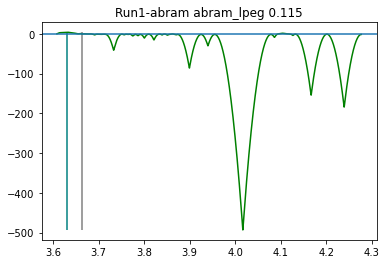

3351.17


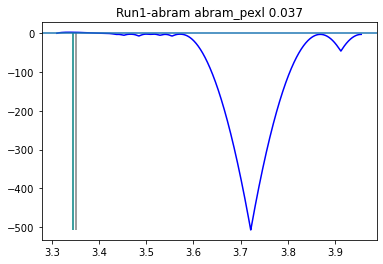

4232.52


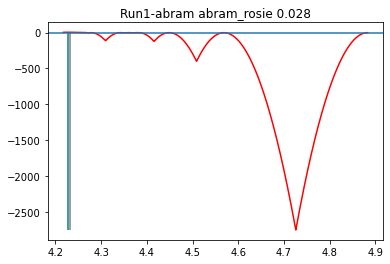

3172.94


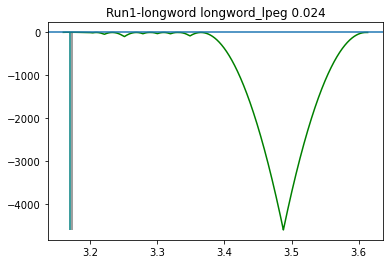

3011.22


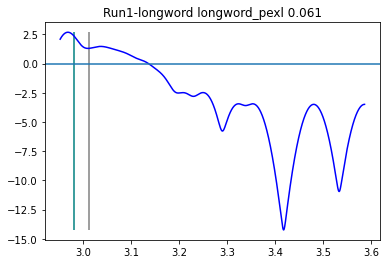

3798.2


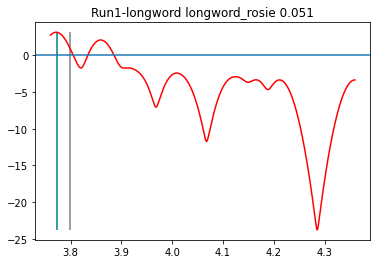

In [40]:
min_max_Dic = {}

for folder in overallDF_Dic.keys():
    #min_max_Dic[name] = (kde_graph(DF_Dic[name].to_numpy(),name,True))
    for DF in overallDF_Dic[folder]:
        #print(type(overallDF_Dic[folder][DF]))
        min_max_Dic[folder+'_'+DF] = (kde_graph(overallDF_Dic[folder][DF].to_numpy(),folder+' '+DF,False))



In [18]:
split_graph_dic = {}

print(min_max_Dic.keys())
for graph in min_max_Dic:
    print(graph)
    mi, ma = min_max_Dic[graph]
    loc_val = zip(mi[0],mi[1])
    temp = []
    folder, prog, name = graph.split('_')
    
    currentDF = overallDF_Dic[folder][prog+'_'+name][name]
    
    temp.append(currentDF.min())
    
    for val in loc_val:
        if val[1] < 0:
            temp.append(val[0])
    
    temp.append(currentDF.max())
    
    split_graph_dic[graph] = []
    
    for counter in range(1,len(temp)):
        if counter == len(temp)-1:
            split_graph_dic[graph].append(currentDF[[ test for test in currentDF >= temp[counter-1] ]])
        else:
            temp2 = currentDF[[test for test in currentDF >= temp[counter - 1] ] ]
            split_graph_dic[graph].append(temp2[[test for test in temp2 < temp[counter] ] ])
            
    sum_counter = 0
    for lists in split_graph_dic[graph]:
        sum_counter += len(lists)
    
    assert sum_counter == len(currentDF),('Missing/Double Counted Data in splitting set '+graph)

dict_keys(['Run2-abram_abram_lpeg', 'Run3-abram_abram_lpeg', 'Run1-abram_abram_lpeg'])
Run2-abram_abram_lpeg
Run3-abram_abram_lpeg
Run1-abram_abram_lpeg


Attempting to combine all the data into one set to look at distrobution of clock times.

In [42]:
bar_graph_Dic = {}
for graph in split_graph_dic:
    print(graph)
    bar_graph_Dic[graph] = []
    for lists in split_graph_dic[graph]:
        length = len(lists)
        #print(length)
        bar_graph_Dic[graph].append(length)
bar_graph_Dic.keys()

Run2-abram_abram_lpeg
Run3-abram_abram_lpeg
Run1-abram_abram_lpeg


dict_keys(['Run2-abram_abram_lpeg', 'Run3-abram_abram_lpeg', 'Run1-abram_abram_lpeg'])

Run2-abram
abram_lpeg


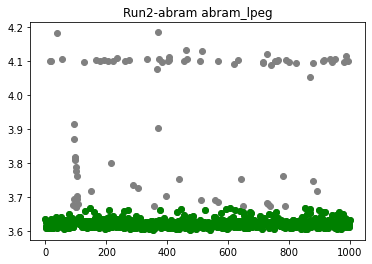

Mean of 1st Regime is 3.6232 vs Mean of Whole is 3.6508 

Standard Deviation of 1st Regime is 0.0104 vs Stand Deviation of Whole is 0.1065 

Run3-abram
abram_lpeg


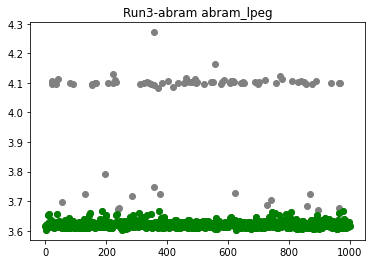

Mean of 1st Regime is 3.6228 vs Mean of Whole is 3.6573 

Standard Deviation of 1st Regime is 0.0098 vs Stand Deviation of Whole is 0.123 

Run1-abram
abram_lpeg


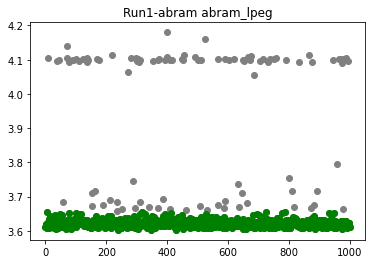

Mean of 1st Regime is 3.6223 vs Mean of Whole is 3.6567 

Standard Deviation of 1st Regime is 0.0091 vs Stand Deviation of Whole is 0.1205 



In [40]:
def JamieSuggestion(folder,pattern):
    
    tempDF = overallDF_Dic[folder][pattern]
    name = tempDF.columns[0]
    SplitKey = folder+'_'+pattern

    if name.find('lpeg') != -1:
        color = 'green'
    elif name.find('pexl') != -1:
        color = 'blue'
    elif name.find('rosie') != -1:
        color = 'red'

    plt.scatter(tempDF[name].index, tempDF[name], color = 'grey')

    #if name.find('lpeg') != -1:
    #    color = 'cyan'
    #elif name.find('pexl') != -1:
    #    color = 'darkorange'
    #elif name.find('rosie') != -1:
    #    color = 'indigo'

    plt.scatter(split_graph_dic[SplitKey][0].index, split_graph_dic[SplitKey][0], color = color)
    
    stand_dev = round(np.std(split_graph_dic[SplitKey][0]),4)
    mean = round(np.mean(split_graph_dic[SplitKey][0]),4)
    stand_dev_whole = round(np.std(tempDF[name]),4)
    mean_whole = round(np.mean(tempDF[name]),4)
    
    plt.title(folder+' '+pattern)
    plt.show()
    
    
    print('Mean of 1st Regime is',mean,'vs Mean of Whole is',mean_whole,'\n')
    #print('A change of',round( (mean_whole/(mean_whole-mean)*100),4),'% in the Mean\n' )
    print('Standard Deviation of 1st Regime is',stand_dev,'vs Stand Deviation of Whole is',stand_dev_whole,'\n')
    #print('A change of',round( (stand_dev_whole/(stand_dev_whole-stand_dev)*100),4),'% in the Stand Deviation'  )
    
for folder in overallDF_Dic:
    print(folder)
    for pattern in overallDF_Dic[folder]:
        print(pattern)
        JamieSuggestion(folder,pattern)

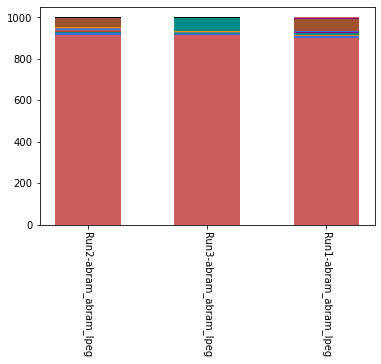

In [41]:
#labels = bar_graph_Dic.keys()
width = .55
colorList = ['indianred','royalblue','darkorange','darkcyan','sienna','darkmagenta','slategray','black']

fig, ax = plt.subplots()


for label in bar_graph_Dic.keys():
    count = 0
    sums = 0
    for num in bar_graph_Dic[label]:
        if count == 0:
            ax.bar(label,num,width,label=label, color = colorList[count])
            sums = num
        else:
            ax.bar(label,num,width, bottom = sums, label=count ,color = colorList[count%len(colorList)])
            sums += num
        count += 1
#ax.legend()
plt.xticks(rotation=270)
plt.show();